# Introduction to basic functionalities of flowerMD

## Overview:

This tutorial introduces some basic functionalities of the flowerMD package including:

- Initializing molecule structures
- Assembling molecules in a box
- Applying force fields
- Running MD simulations using different methods




## Step-by-step guide for running MD simulation for a box of  Polyphenylene sulfide (PPS) polymers:
In this tutorial, we will run a molecular dynamics simulation of Polyphenylene sulfide (PPS) polymers using the flowerMD package.
flowerMD uses the [`HOOMD-blue`](https://hoomd-blue.readthedocs.io/en/v4.1.0/) simulation engine in the background to run different methods of simulation, and utilizes many functionalities from [`mBuild`](https://mbuild.mosdef.org/en/stable/) and [GMSO](https://gmso.mosdef.org/en/stable/) to initialize molecular structures, apply forcefields and prepare the information necessary to run a simulation.

In summary, the flowerMD package has three main classes:

-  `Molecule`: This class is used to define the structure of a molecule (for example the structure of a polymer built from a monomer). This class allows us to implement recipies for building complex structures.

- `System`: This class is used to assemble molecules into a box and to capture the initial `gsd` snapshot of the system. It also applies the forcefiled to the system and prepares the required forces for the simulation.

- `Simulation`: This class is used to run the simulation using the `HOOMD-blue` simulation engine in the background. The Simulation class provides additional functionalities to run simulations following different processes/methods.

In [2]:
!mamba install flowermd


Looking for: ['flowermd']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.10.*
  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import flowermd

/usr/local/lib/python3.10/site-packages/mbuild/packing.py:23: DeprecationWarning: Use shutil.which instead of find_executable
  PACKMOL = find_executable("packmol")


### Step 1: Initializing the Molecule
In this example, we are using the pre-defined recipe for building PPS molecules defined in flowerMD's library. The `PPS` class is a subclass of the `Molecule` class. This class includes all the necessary information for building the PPS chains, including the monomer structure and how the monomers bond to create a chain. All we need to specify is the polymer chain length and how many polymer chains we want to create. In this example, we will create a system of 10 PPS chains with a length of 8.

In [5]:
from flowermd.library import PPS

molecules = PPS(num_mols=10, lengths=8)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Step 2: Initializing the System
In this step, we will use the `Pack` class, which is a subclass of the `System` class, to pack a box of PPS molecules in a random fashion at a given density (density unit is $g/cm^3$). The `System` class creates the box, organizes molecules within the box, applies the forcefield (if provided) to the system and creates
the initial state of the system in form of a HOOMD snapshot.
The `apply_forcefield` method in `System`, applies the forcefield (works only for XML-based forcefields) to the system and generates the list of HOOMD force objects defining bonded and non-bonded interactions.

Alternatively, users can initiate their own custom list of HOOMD force objects. In such cases, there is no need to call `apply_forcefield` method or specify the `force_field` parameter during system setup. Instead, a list of `hoomd.md.force.Force` objects are passed directly to the `Simulation` class in the subsequent step. This approach allows for a greater flexibility in customizing the force interactions within the simulation, especially in cases where XML-based forcefields are not available. For more examples, see [the coarse graining tutorial](3-coarse-graining.ipynb).

#### Step 2.1: Creating the box and placing molecules

In this example, the `Pack` class invokes mBuild's `fill_box` method in the background, which efficiently places molecules within a box in a randomized manner without overlaps. This method uses [PACKMOL](https://m3g.github.io/packmol/) to fill the box.

**A note on `density` and `packing_expand_factor` parameters:**

Given a density in $\dfrac{g}{cm^3}$, the system class calculates a box length that corresponds to the specified density. We refer to calculated length as `target_box`. The `packing_expand_factor` multiplies this calulated box length by a factor and initializes the system based on the expanded box length. The reason for this expansion is that sometimes `PACKMOL` might fail to arrange molecules if the box size is too small. To address this, we suggest initially using an expand factor (default is 5) to initiate the system. Afterward, once the simulation object is created, we can shrink the simulation box to the desired target density.

The `density` parameter in the `Pack` class assumes $\dfrac{g}{cm^3}$ by default. It can work with other units, or even other kinds of density (e.g. number density instead of mass density). `flowerMD` uses the [unyt](https://github.com/yt-project/unyt). package for handling different kinds of units.

In [6]:
from flowermd.base import Pack
system = Pack(molecules=molecules, density=0.5, packing_expand_factor=5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Step 2.2: Applying Forcefield

Now that the molecules are packed in the box, we can apply the forcefield and parameterize particle interactions.
We use the pre-defined `OPLS` forcefield class, which was created from the [OPLS](https://en.wikipedia.org/wiki/OPLS) XML forcefield, to parameterize particle interactions.

The flowerMD library offers some commonly used forcefields that can be employed to parameterize the interactions within specific systems. Please refer to [flowerMD's documentation](https://flowermd.readthedocs.io/en/latest/forcefields.html) for more examples.


We also specify the `r_cut` parameter, which is the cutoff distance for the non-bonded interactions. If `auto_scale` is set to `True`, all the parameters defined in forces will be scaled. For example, all the `epsilon` values of Leonard-Jones potentials are scaled based on the maximum `epsilon` value. Also, `scale_charges=True` will make the system charge neutral.

In [7]:
from flowermd.library import OPLS_AA_PPS

system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True, scale_charges=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The initial snapshot can be acquired from the `system.hoomd_snapshot` object.


In [8]:
system.hoomd_snapshot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The list of HOOMD force objects applied to the system can also be obtained by accessing the `system.hoomd_forcefield` attribute. These forces correspond to the bonded and non-bonded interactions parameterized from the `OPLS` forcefield.

In [9]:
hoomd_forces = system.hoomd_forcefield
hoomd_forces

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now, let's examine the parameters of the LJ pair force. As you can see, the values of `epsilon` have been scaled to fall within the range of  0 to 1. The scaling factor for the `epsilon` parameter, which is expressed in units of energy, can be retrieved  from `system.reference_energy`.

In [10]:
lj_force = hoomd_forces[3]

dict(lj_force.params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{('ca',
  'ca'): _HOOMDDict{'epsilon': 0.16470588235294115, 'sigma': 0.9861111111111112},
 ('ca',
  's'): _HOOMDDict{'epsilon': 0.37091488871610456, 'sigma': 0.9930312739844155},
 ('ca',
  'ha'): _HOOMDDict{'epsilon': 0.10782531046954916, 'sigma': 0.8141779918845362},
 ('ca',
  'sh'): _HOOMDDict{'epsilon': 0.40583972495671383, 'sigma': 0.9930312739844155},
 ('ca', 'hs'): _HOOMDDict{'epsilon': 0.0, 'sigma': 0.0},
 ('s', 's'): _HOOMDDict{'epsilon': 0.8352941176470587, 'sigma': 1.0},
 ('ha',
  's'): _HOOMDDict{'epsilon': 0.2428207934182387, 'sigma': 0.8198915917499229},
 ('s', 'sh'): _HOOMDDict{'epsilon': 0.9139442639718566, 'sigma': 1.0},
 ('hs', 's'): _HOOMDDict{'epsilon': 0.0, 'sigma': 0.0},
 ('ha',
  'ha'): _HOOMDDict{'epsilon': 0.07058823529411763, 'sigma': 0.6722222222222223},
 ('ha',
  'sh'): _HOOMDDict{'epsilon': 0.2656844656620285, 'sigma': 0.8198915917499229},
 ('ha', 'hs'): _HOOMDDict{'epsilon': 0.0, 'sigma': 0.0},
 ('sh', 'sh'): _HOOMDDict{'epsilon': 0.9999999999999999, 'sigma

### Step 3: Running the Simulation

Using the snapshot and force objects provided by the `System` class in the previous step, we can proceed to initialize the simulation. The `Simulation` class, a subclass of `hoomd.Simulation`, offers additional features and functionalities that automate simulation methods, such as updating box volume, welding process and tensile tests.

**A note about Logging**

In addition, the Simulation class provides the functionality to log snapshots of the simulation as a `gsd` trajectory file while the simulation is running. The frequency of saving these snapshots into the gsd file is controlled by the `gsd_write_freq` parameter. Furthermore, the path and name of the trajectory file is specified using the `gsd_file_name` parameter, with the default being "trajectory.gsd".

The simulation objects automatically log various simulation data, including timestep, potential energy, kinetic temperature, pressure, and volume. These data are saved in a text file, and you can specify the name of this file using the `log_file_name` parameter (the default is sim_data.txt). The frequency at which this data is logged can be set using the `log_write_freq` parameter. These features allow for the efficient monitoring and analysis of simulation progress and results.

In [11]:
from flowermd.base import Simulation

sim = Simulation.from_system(system=system, gsd_write_freq=100, log_write_freq=100)

Initializing simulation state from a gsd.hoomd.Frame.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can access simulation box length and shrink the volume to reach the **desired density** specified in the system.

`flowermd.utils` has helper functions for finding the box size that corresponds to a desired density. We can use this to get target box
lengths to use in a short shrink simulation.

`get_target_box_mass_density` returns the box lengths in units of $cm$ since the density is given in $\dfrac{g}{cm^3}$.
This is okay, and we can pass this box directly to the `sim.run_update_volume`. The simulation class will handle any needed conversions.

In [12]:
from flowermd.utils import get_target_box_mass_density

target_box = get_target_box_mass_density(density=system.density, mass=system.mass.to("g"))
print(target_box)

[3.06534572e-07 3.06534572e-07 3.06534572e-07] cm


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can use the `density` proprety of the `Simulation` class to see the current density of the system.
Here, before running a shrink simulation, we can see the density is much lower than our target density of $0.5 \dfrac{g}{cm^3}$.
We will call `run_update_volume`, pass in `target_box` and check the density of the simulation afterward. It should match the target density.

In [13]:
sim.density.to("g/cm**3")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


unyt_quantity(0.004, 'g/cm**3')

In [14]:
sim.run_update_volume(n_steps=1000, period=1, kT=1, tau_kt=1, final_box_lengths=target_box)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
*Warning*: charge.pppm: RMS error of 0.500587 is probably too high! 0.500587 0.500484


Step 100 of 1000; TPS: 121.56; ETA: 0.1 minutes
Step 200 of 1000; TPS: 165.72; ETA: 0.1 minutes
Step 300 of 1000; TPS: 188.29; ETA: 0.1 minutes
Step 400 of 1000; TPS: 200.17; ETA: 0.0 minutes
Step 500 of 1000; TPS: 203.36; ETA: 0.0 minutes
Step 600 of 1000; TPS: 204.8; ETA: 0.0 minutes
Step 700 of 1000; TPS: 202.15; ETA: 0.0 minutes
Step 800 of 1000; TPS: 196.52; ETA: 0.0 minutes
Step 900 of 1000; TPS: 186.98; ETA: 0.0 minutes
Step 1000 of 1000; TPS: 169.29; ETA: 0.0 minutes


In [15]:
sim.density.to("g/cm**3")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


unyt_quantity(0.5, 'g/cm**3')

Visualizing the first and last frame of the saved trajectory shows the effect of shrinking on box size.

In [ ]:
import hoomd
for writer in sim.operations.writers:
    if isinstance(writer, hoomd.write.GSD):
        writer.flush()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


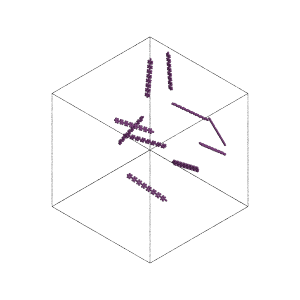

In [ ]:
from cmeutils.visualize import FresnelGSD

sim_visualizer = FresnelGSD(gsd_file="trajectory.gsd", frame=0, view_axis=(1, 1, 1))
sim_visualizer.view()


last frame:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


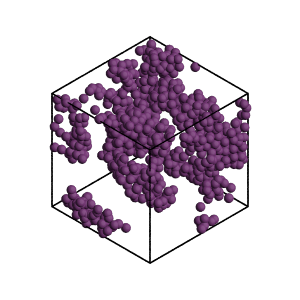

In [ ]:
sim_visualizer.frame = -1
sim_visualizer.view()

Let's run the simulation for 1000 time steps using the NVT ensemble at a scaled temperature of 1.0. The default thermostat in flowerMD simulations is Nosé-Hoover thermostat. Users can modify the thermostat by specifying the `thermostat` parameter during the initialization of the simulation object. Users can select from a range of available thermostats, which are defined in  [`flowermd.utils.base_types.HOOMDThermostats`](https://github.com/cmelab/flowerMD/blob/main/flowermd/utils/base_types.py). For more detailed information about thermostats please refer to [HOOMD Blue documentation](https://hoomd-blue.readthedocs.io/en/stable/module-md-methods-thermostats.html).

In [ ]:
sim.run_NVT(n_steps=2000, kT=1.0, tau_kt=0.01)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step 99 of 2000; TPS: 86.07; ETA: 0.4 minutes
Step 199 of 2000; TPS: 87.36; ETA: 0.3 minutes
Step 299 of 2000; TPS: 88.29; ETA: 0.3 minutes
Step 399 of 2000; TPS: 89.16; ETA: 0.3 minutes
Step 499 of 2000; TPS: 89.44; ETA: 0.3 minutes
Step 599 of 2000; TPS: 89.94; ETA: 0.3 minutes
Step 699 of 2000; TPS: 89.82; ETA: 0.2 minutes
Step 799 of 2000; TPS: 85.18; ETA: 0.2 minutes
Step 899 of 2000; TPS: 80.95; ETA: 0.2 minutes
Step 999 of 2000; TPS: 79.97; ETA: 0.2 minutes
Step 1099 of 2000; TPS: 80.84; ETA: 0.2 minutes
Step 1199 of 2000; TPS: 81.73; ETA: 0.2 minutes
Step 1299 of 2000; TPS: 82.5; ETA: 0.1 minutes
Step 1399 of 2000; TPS: 83.25; ETA: 0.1 minutes
Step 1499 of 2000; TPS: 83.75; ETA: 0.1 minutes
Step 1599 of 2000; TPS: 84.32; ETA: 0.1 minutes
Step 1699 of 2000; TPS: 84.91; ETA: 0.1 minutes
Step 1799 of 2000; TPS: 85.39; ETA: 0.0 minutes
Step 1899 of 2000; TPS: 85.28; ETA: 0.0 minutes
Step 1999 of 2000; TPS: 83.45; ETA: 0.0 minutes


In [ ]:
for writer in sim.operations.writers:
    if isinstance(writer, hoomd.write.GSD):
        writer.flush()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


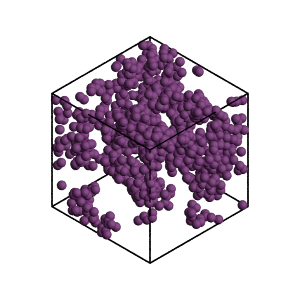

In [ ]:
sim_visualizer.frame=-1
sim_visualizer.view()

The simulation class also allows users to run the simulation under different conditions/ensembles such as NPT ensemble, NVE ensemble and Langevin dynamics. Check out [flowerMD's documentation](https://flowermd.readthedocs.io/en/latest/simulation.html) for more functionalities.


In the upcoming tutorials, we will explore a selection of features offered by the flowerMD package, highlighting how they can be customized to meet specific research requirements.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
